In [1]:
import numpy as np
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from collections import namedtuple, deque

In [2]:
#Network Model

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=5, fc2_units=5):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.ln1 = nn.LayerNorm(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.ln2 = nn.LayerNorm(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = state
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return torch.tanh(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=20, fc2_units=10):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.fc1(state)
        xs = self.bn1(xs)
        xs = F.leaky_relu(xs)
        x = torch.cat((xs, action), dim=1)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        return self.fc3(x)

In [3]:
#Agent

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-2         # learning rate of the actor
LR_CRITIC = 5e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
EPSILON_MAX = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 1e-6
LEARN_START = 20000
UPDATE_EVERY = 1
UPDATES_PER_STEP = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON_MAX

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed, mu=0, theta=0.15, sigma=0.2)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        # Make sure target is with the same weight as the source
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

        self.t_step = 0

    def step(self, state, action, reward, next_state, done, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward        
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > LEARN_START:
            # Learn every UPDATE_EVERY time steps.
            self.t_step = (self.t_step + 1) % UPDATE_EVERY
            if self.t_step == 0:
                # Learn, if enough samples are available in memory
                if len(self.memory) > BATCH_SIZE:
                    for _ in range(UPDATES_PER_STEP):
                        experiences = self.memory.sample()
                        self.learn(experiences, GAMMA)

    def act(self, state, add_noise):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()

        self.actor_local.train()

        if add_noise:
            action += self.epsilon * self.noise.sample()

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + ? * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # ---------------------------- update noise ---------------------------- #
        if self.epsilon - EPSILON_DECAY > EPSILON_MIN:
            self.epsilon -= EPSILON_DECAY
        else:
            self.epsilon = EPSILON_MIN

        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        ?_target = t*?_local + (1 - t)*?_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

        self.reset()

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def reset(self):
        self.memory = deque(maxlen=self.buffer_size)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [4]:
#Noise

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [5]:
import gym.spaces
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

from itertools import count
import time

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [6]:
random_seed = 2

env = gym.make('MountainCarContinuous-v0')
env.seed(random_seed)

# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

# examine the state space 
state_size = env.observation_space.shape[0]
print('Size of state:', state_size)

action_low = env.action_space.low
print('Action low:', action_low)

action_high = env.action_space.high
print('Action high: ', action_high)

Size of each action: 1
Size of state: 2
Action low: [-1.]
Action high:  [1.]


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)


In [8]:
def save_model(actor_path,critic_path):
    print("Model Save...")
    torch.save(agent.actor_local.state_dict(), actor_path)
    torch.save(agent.critic_local.state_dict(), critic_path)

Episode 1, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 4.61
Episode 2, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.80
Episode 3, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.99
Episode 4, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.93
Episode 5, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.88
Episode 6, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.45
Episode 7, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.47
Episode 8, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 9, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 10, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 11, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 12, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 13, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.46
Episode 14, Average Score: -5.45, Max: -5.45, Min: -5.45, Time: 0.45
Episode 15, Average Score: -5.45, Max: -5.4

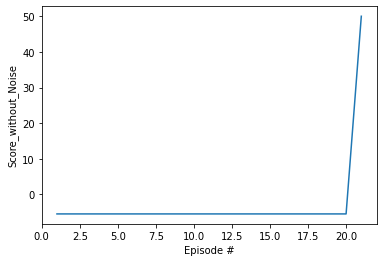

In [9]:
def ddpg(n_episodes=1000, max_t=500, print_every=1, save_every=50,b_noise=False,actor_path='cp_a.pth',critic_path='cp_c.pth'):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        timestep = time.time()
        for t in range(max_t):
            action = agent.act(state,b_noise)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done, t)
            score += reward
            state = next_state            
            if done:
                break 
                
        scores_deque.append(score)
        scores.append(score)
        score_average = np.mean(scores_deque)
        
        if i_episode % save_every == 0:
            save_model(actor_path,critic_path)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")
                    
        if np.mean(scores_deque) >= 50.0:            
            save_model(actor_path,critic_path)
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))            
            break            
            
            
    return scores

scores = ddpg(n_episodes=100000, max_t=50000, print_every=1, save_every=100,b_noise=False,actor_path='cp_actorM1.pth',critic_path='cp_criticM1.pth')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score_without_Noise')
plt.xlabel('Episode #')
plt.show()



DDPG with noise

Episode 1, Average Score: -7.16, Max: -7.16, Min: -7.16, Time: 7.63
Episode 2, Average Score: -8.19, Max: -7.16, Min: -8.19, Time: 7.57
Episode 3, Average Score: -20.47, Max: -7.16, Min: -20.47, Time: 12.83
Episode 4, Average Score: -6.05, Max: -6.05, Min: -20.47, Time: 7.39
Episode 5, Average Score: -47.41, Max: -6.05, Min: -47.41, Time: 7.49
Episode 6, Average Score: -59.98, Max: -6.05, Min: -59.98, Time: 12.36
Episode 7, Average Score: -58.95, Max: -6.05, Min: -59.98, Time: 7.37
Episode 8, Average Score: -99.89, Max: -6.05, Min: -99.89, Time: 7.44
Episode 9, Average Score: -79.60, Max: -6.05, Min: -99.89, Time: 7.41
Episode 10, Average Score: -35.34, Max: -6.05, Min: -99.89, Time: 7.30
Episode 11, Average Score: -23.08, Max: -6.05, Min: -99.89, Time: 7.34
Episode 12, Average Score: -16.62, Max: -6.05, Min: -99.89, Time: 8.28
Episode 13, Average Score: -53.78, Max: -6.05, Min: -99.89, Time: 7.41
Episode 14, Average Score: -66.62, Max: -6.05, Min: -99.89, Time: 8.18
Episode 15, Averag

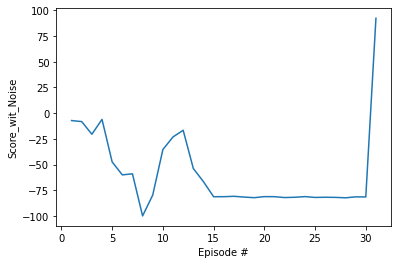

In [10]:
def ddpg_noise(n_episodes=1000, max_t=500, print_every=1, save_every=50,b_noise=True,actor_path='cp_a.pth',critic_path='cp_c.pth'):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        timestep = time.time()
        for t in range(max_t):
            action = agent.act(state,b_noise)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done, t)
            score += reward
            state = next_state            
            if done:
                break 
                
        scores_deque.append(score)
        scores.append(score)
        score_average = np.mean(scores_deque)
        
        if i_episode % save_every == 0:
            save_model(actor_path,critic_path)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")
                    
        if np.mean(scores_deque) >= 50.0:            
            save_model(actor_path,critic_path)
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))            
            break            
            
            
    return scores

scores2 = ddpg_noise(n_episodes=100000, max_t=50000, print_every=1, save_every=100,b_noise=True,actor_path='cp_actorM2.pth',critic_path='cp_criticM2.pth')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(np.arange(1, len(scores2)+1), scores2)
plt.ylabel('Score_wit_Noise')
plt.xlabel('Episode #')
plt.show()



Size of each action: 1

Size of state: 2

**without Noise**  Environment solved in 21 episodes!	Average Score: 50.04

**with Noise**  Environment solved in 31 episodes!	Average Score: 92.32